In [4]:
from src.data_download import initialize_gee, download_dem
from src.calculations import calculate_terrain_attributes
from src.plotting import plot_all_bands, plot_individual_attribute
from src.utils import tiff_to_xarray, combine_xarrays
import os

Создадим пример - GeoJson файл с координатами области 
```
lat, lon = 55.600, 37.172
buffer = 0.1
```


In [1]:
import json

lat, lon = 55.600, 37.172
buffer = 0.1
min_lat = lat - buffer
max_lat = lat + buffer
min_lon = lon - buffer
max_lon = lon + buffer

sample_geojson = {
    "type": "FeatureCollection",
    "features": [
        {
            "type": "Feature",
            "geometry": {
                "type": "Polygon",
                "coordinates": [
                    [
                        [min_lon, min_lat],
                        [max_lon, min_lat],
                        [max_lon, max_lat],
                        [min_lon, max_lat],
                        [min_lon, min_lat]
                    ]
                ]
            },
            "properties": {
                # В данном примере отсутствует временной промежуток → null
                "time": None,
                # Поскольку передается прямоугольный полигон → true
                "is_rectangle": True
            }
        }
    ]
}

# Сохраним GeoJSON в файл
with open("sample.geojson", "w", encoding="utf-8") as f:
    json.dump(sample_geojson, f, ensure_ascii=False, indent=2)

In [5]:
# Инициализируем GEE
initialize_gee(project='projectomela')

# Определим координаты и названия файлов
geojson_path = "sample.geojson"
dem_file_name = "srtm.tif"
directory = "example_output"

# Загрузим DEM из GEE (DEM сохранится в tiff файл в директории directory)
dem_xarray = download_dem(geojson_path, dem_file_name, directory)
# Путь к DEM файлу
dem_path = os.path.join(directory, dem_file_name)
dem_xarray

Google Earth Engine успешно инициализирован.
Generating URL ...
Please wait ...
Data downloaded to c:\Users\Asus\dem_api\examples\srtm.tif
DEM downloaded to example_output\srtm.tif


<xarray.DataArray (band: 1, y: 743, x: 743)> Size: 1MB
[552049 values with dtype=int16]
Coordinates:
  * band         (band) int32 4B 1
  * x            (x) float64 6kB 37.07 37.07 37.07 37.07 ... 37.27 37.27 37.27
  * y            (y) float64 6kB 55.7 55.7 55.7 55.7 ... 55.5 55.5 55.5 55.5
    spatial_ref  int32 4B 0
Attributes:
    AREA_OR_POINT:           Area
    TIFFTAG_RESOLUTIONUNIT:  1 (unitless)
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1
    _FillValue:              -32768
    scale_factor:            1.0
    add_offset:              0.0

In [6]:
# Определим, какие аттрибуты мы хотим считать
attributes = [
    'slope', 'hillshade', 'aspect', 'curvature', 'planform_curvature', 'profile_curvature',
    'maximum_curvature', 'topographic_position_index', 'terrain_ruggedness_index',
    'roughness', 'rugosity'
]

# Получаем список из len(attributes) + 1 объектов Xarray; также сохраняем их как GeoTIFF файлы
attribute_xarrays = calculate_terrain_attributes(dem_path, attributes, directory)
attribute_xarrays[1]

Coordinate system before reprojection Ellipsoid
Coordinate system after reprojection EPSG:32637


<xarray.DataArray (band: 1, y: 754, x: 441)> Size: 3MB
[332514 values with dtype=float64]
Coordinates:
  * band         (band) int32 4B 1
  * x            (x) float64 4kB 3.782e+05 3.782e+05 ... 3.914e+05 3.914e+05
  * y            (y) float64 6kB 6.174e+06 6.174e+06 ... 6.152e+06 6.152e+06
    spatial_ref  int32 4B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

In [7]:
# Объединим xarray DataArrays в один xarray с несколькими каналами
combined_xarray = combine_xarrays(attribute_xarrays, attributes)

print("Число каналов: ",combined_xarray.band.shape)
print("Названия каналов: ", combined_xarray.band.values)

Число каналов:  (12,)
Названия каналов:  ['reprojected_dem' 'slope' 'hillshade' 'aspect' 'curvature'
 'planform_curvature' 'profile_curvature' 'maximum_curvature'
 'topographic_position_index' 'terrain_ruggedness_index' 'roughness'
 'rugosity']


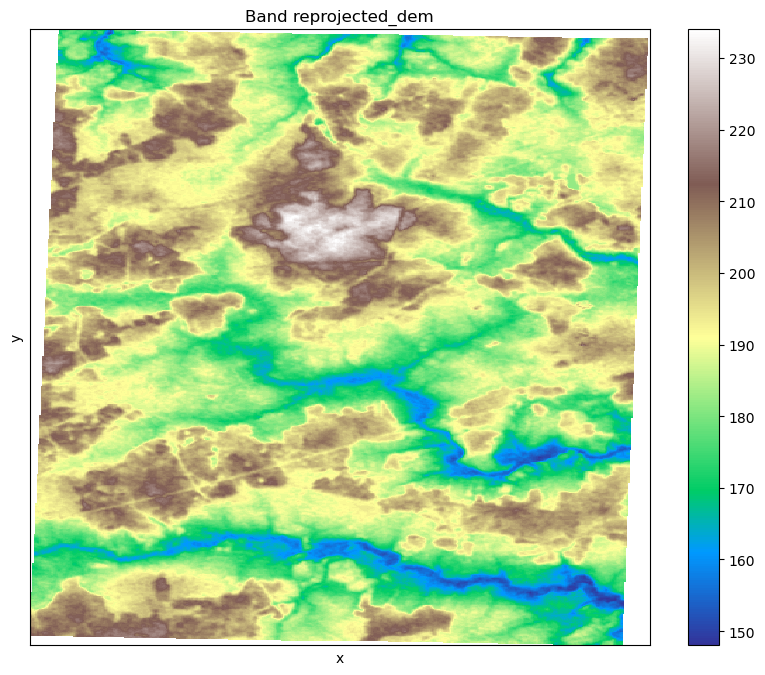

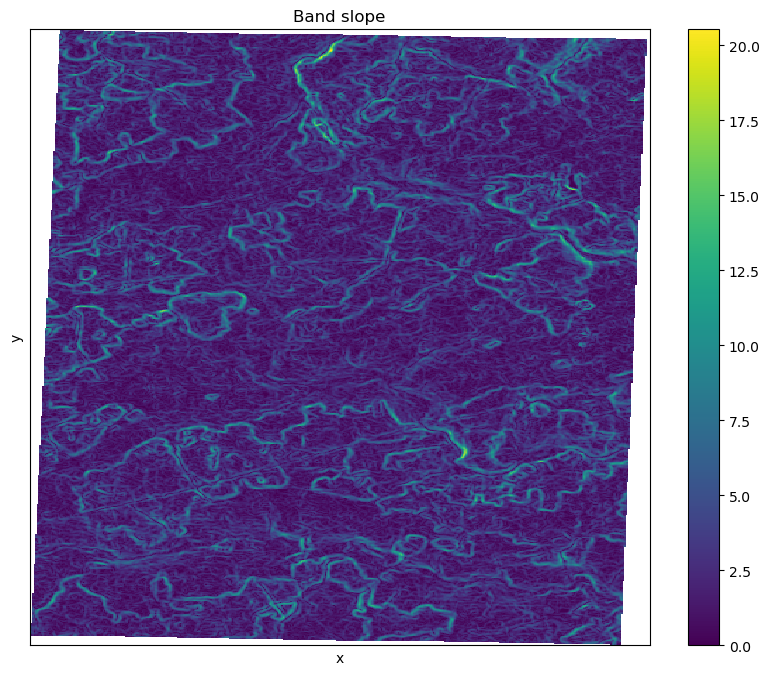

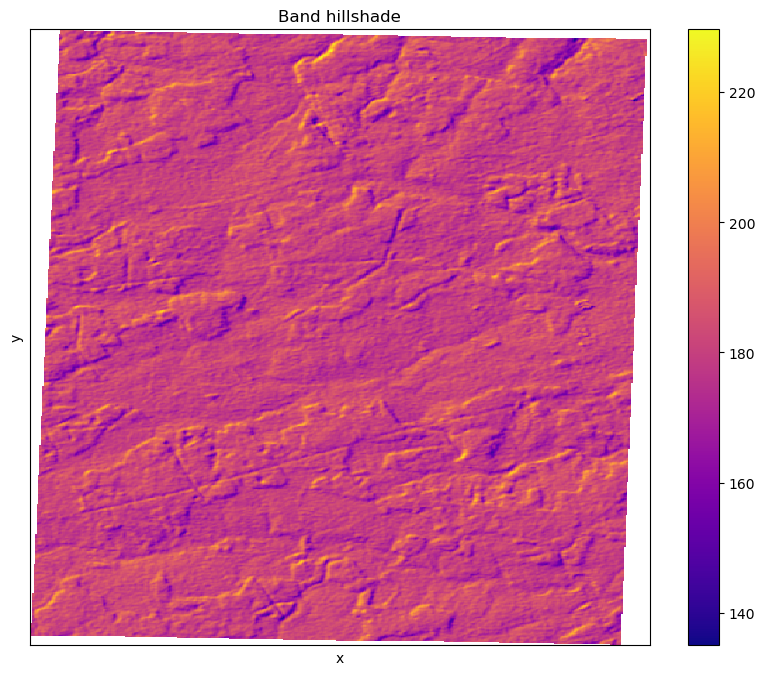

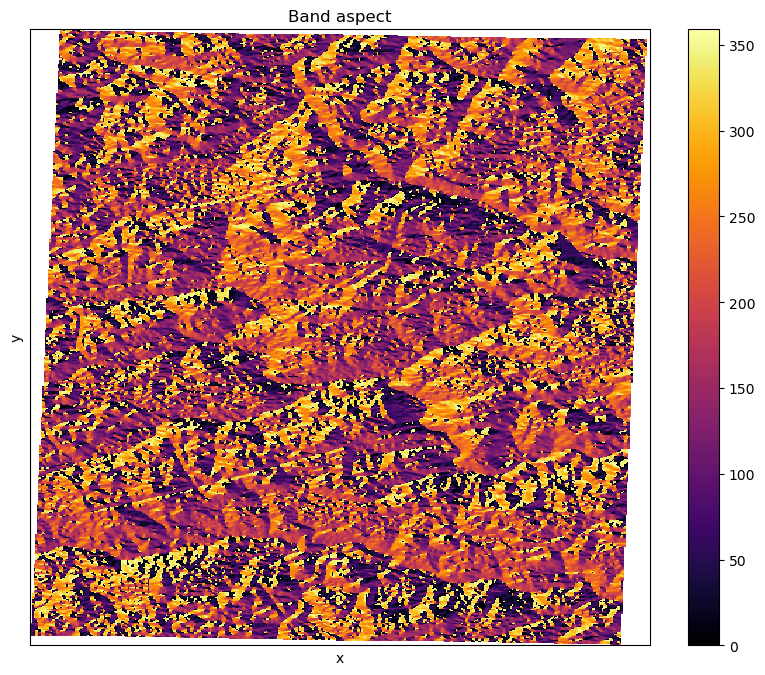

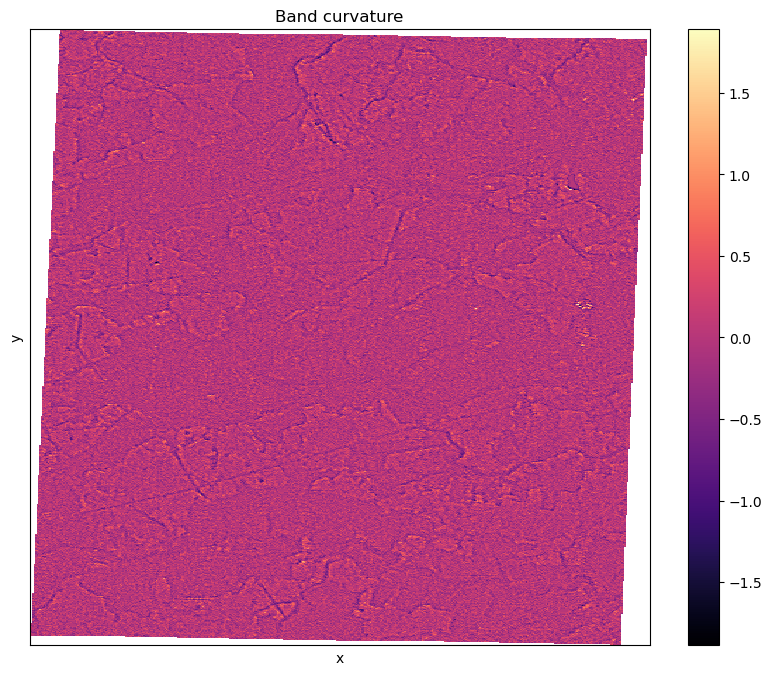

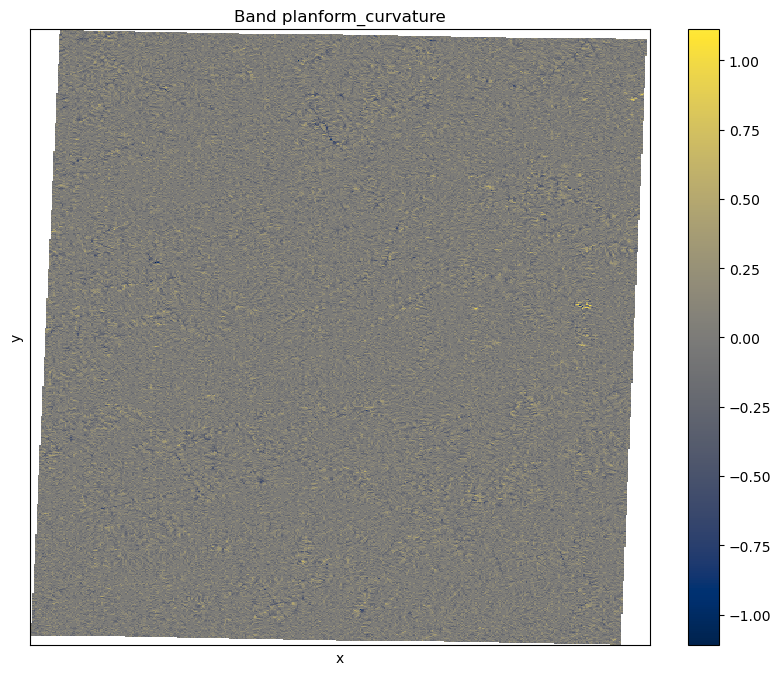

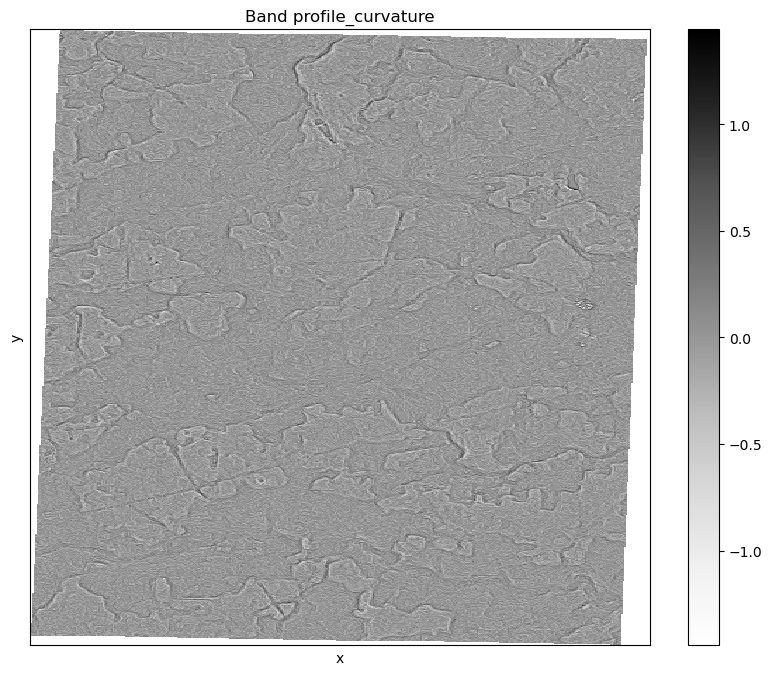

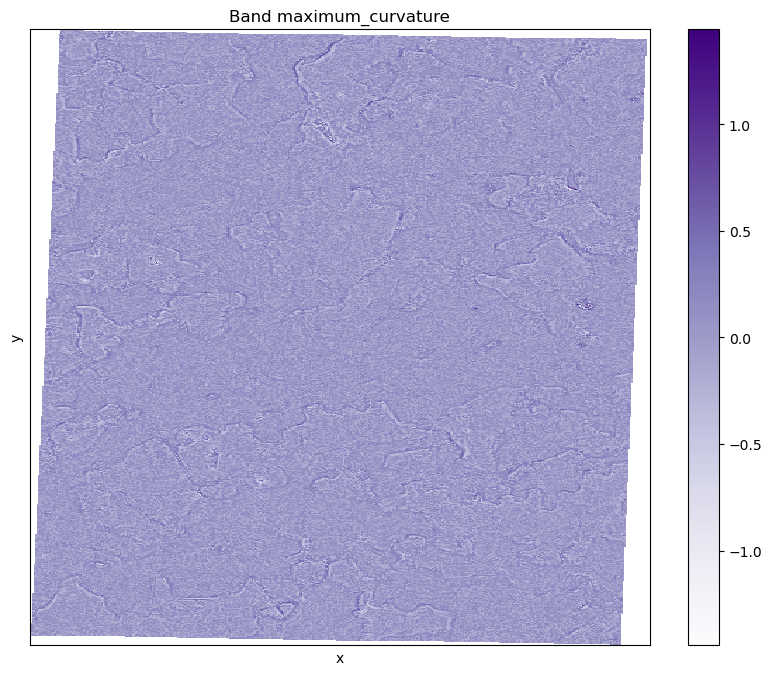

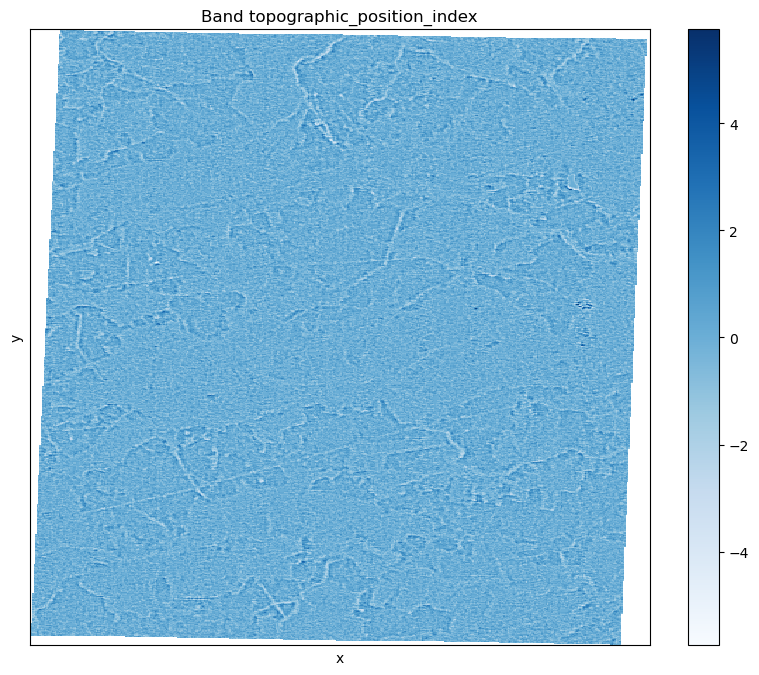

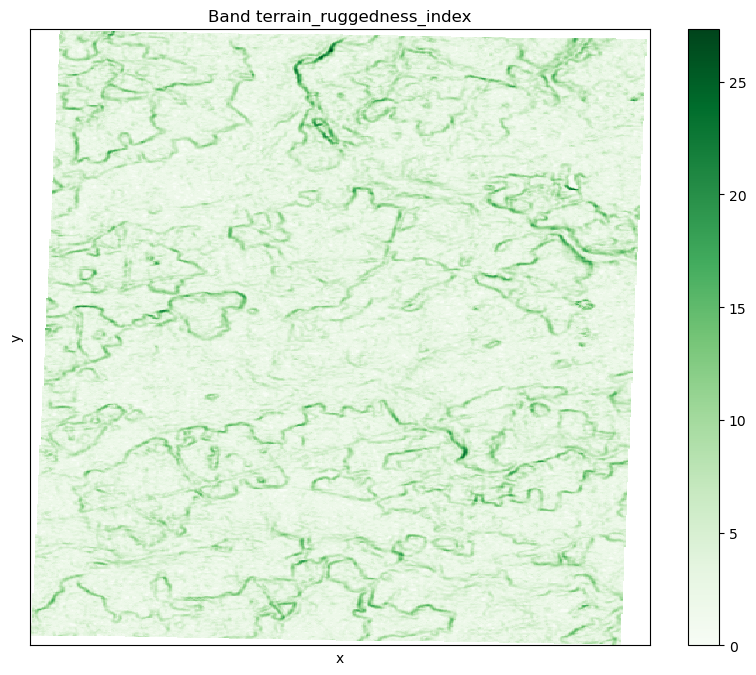

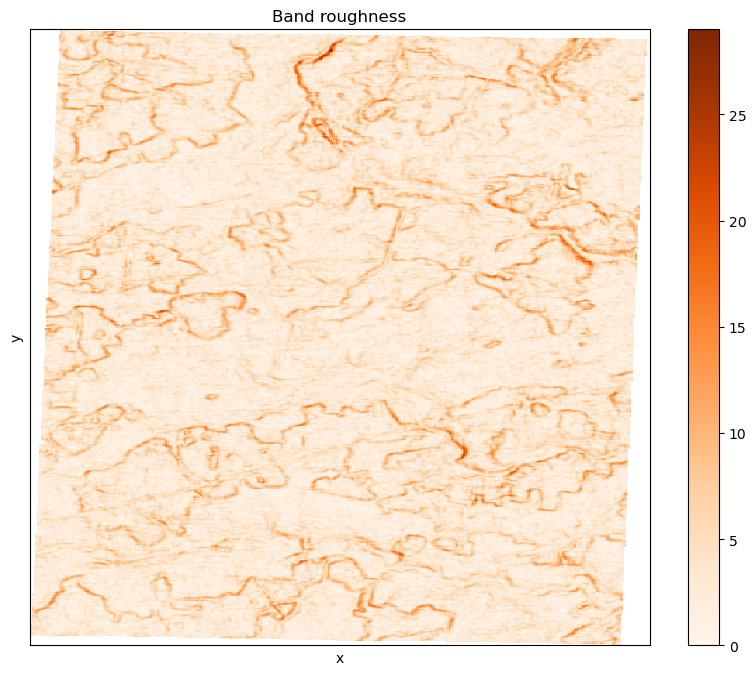

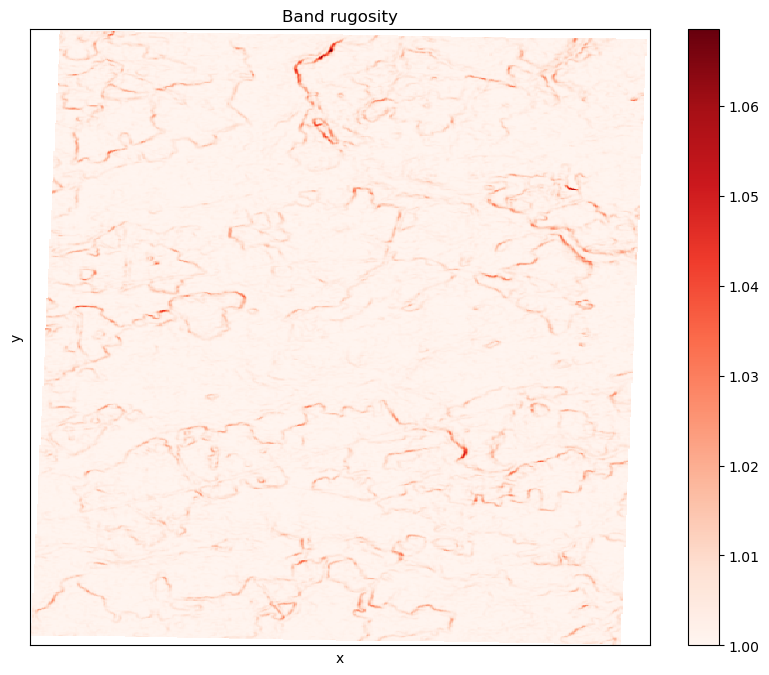

In [8]:
# Вывод кждого канала на отдельном графике
plot_all_bands(combined_xarray)